In [7]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime
from sklearn.utils import shuffle
import keras
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sea
import tensorflow.keras.applications as Applications
import tensorflow.keras.preprocessing.image as ImagePreprocessing
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense ,MaxPool2D ,BatchNormalization,Flatten 
from sklearn.model_selection import KFold
from PIL import Image
import importlib.util
import random as rn
import pandas as pd
from sklearn.model_selection import train_test_split
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers


%load_ext tensorboard

In [12]:
train_split = 0.7
val_split = 0.15
test_split = 0.15
main_dir = 'D:/Academic_PC/Sem 4/Programming_challenge2/'
original_ds_path = main_dir+'kvasir-dataset-v2/'
train_ds_path = original_ds_path+'train/'
val_ds_path = original_ds_path+'validate/'
test_ds_path = original_ds_path+'test/'
base_dir = main_dir+'Xception/'
losses_dir = base_dir+'losses/'
model_save= base_dir+'model_saves/'
seed = 49
size_img = (224,224) #size choosen to preserve the aspect ratio
input_size = (224,224,3)
batch_size = 32

In [13]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [14]:
train_datagen = ImageDataGenerator(featurewise_center=True,
                               samplewise_center=True,
                               featurewise_std_normalization=True,
                               samplewise_std_normalization=True,
                               zca_whitening=False,
                               zca_epsilon=1e-06,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2, 
                               brightness_range=None, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               channel_shift_range=0.0, 
                               fill_mode='nearest', 
                               cval=0.0, 
                               horizontal_flip=True,
                               vertical_flip=True, 
                               rescale=1./255, 
                               preprocessing_function=None,
                               validation_split=0.15
    )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(directory=train_ds_path,
                                                    target_size=size_img,
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    seed=seed,
                                                    )
val_generator = val_datagen.flow_from_directory(directory=val_ds_path,
                                                    target_size=size_img,
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    seed=seed,
                                                    )
test_generator = test_datagen.flow_from_directory(directory=test_ds_path,
                                                    target_size=size_img,
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    seed=seed,
                                                    )

Found 5599 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


In [16]:
Base_Model = tf.keras.applications.InceptionV3(input_tensor=tf.keras.Input(shape=input_size),
                      weights='imagenet',
                      include_top=False)

Base_Model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
for layer in Base_Model.layers:
    layer.trainable = False

In [19]:
conn_layer = Base_Model.get_layer('mixed7')
conn_output = conn_layer.output
x = conn_output 
x = Conv2D(512,(3,3),activation='relu')(x)
x = Conv2D(512,(3,3),activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(8,activation='softmax')(x)

In [20]:
model = tf.keras.Model(inputs=Base_Model.input, outputs=predictions)

In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adamax(lr=1e-2), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       ]
              )

In [23]:
try:
  if not os.path.exists(base_dir+'model_saves'):
    os.mkdir(model_save)
except FileExistsError:
  print('FileExists')

In [24]:
train_history_list = {'initial':[],'secondary':[]}
val_history_list = {'initial':[],'secondary':[]}


In [25]:
for times in range(10):
    history = model.fit(x=train_generator,
                        epochs=5,
                        verbose=1,
                        )
    
    train_history_list['initial'].append(history)
    
    history = model.evaluate(x=val_generator,
                             verbose=1,
                             return_dict = True)
    
    val_history_list['initial'].append(history)

    model.save_weights(model_save+str(times)+'_init.h5')

C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
175/175 [==============================] - 270s 2s/step - loss: 0.8072 - accuracy: 0.6855
Epoch 2/5
175/175 [==============================] - 121s 689ms/step - loss: 0.5393 - accuracy: 0.7805
Epoch 3/5
175/175 [==============================] - 118s 672ms/step - loss: 0.4952 - accuracy: 0.8005
Epoch 4/5
175/175 [==============================] - 116s 661ms/step - loss: 0.4575 - accuracy: 0.8182
Epoch 5/5
38/38 [==============================] - 40s 1s/step - loss: 0.6135 - accuracy: 0.7508
Epoch 1/5
175/175 [==============================] - 118s 675ms/step - loss: 0.4191 - accuracy: 0.8375
Epoch 2/5
175/175 [==============================] - 118s 672ms/step - loss: 0.4135 - accuracy: 0.8384
Epoch 3/5
175/175 [==============================] - 117s 669ms/step - loss: 0.3919 - accuracy: 0.8457
Epoch 4/5
175/175 [==============================] - 118s 673ms/step - loss: 0.3967 - accuracy: 0.8512
Epoch 5/5
38/38 [==============================] - 16s 421ms/step - loss: 0.6725 -

In [26]:
try:
  if not os.path.exists(base_dir+'losses'):
    os.mkdir(losses_dir)
except FileExistsError:
  print('Folder exists')


In [27]:
train_history = []
for each in train_history_list['initial']:
  print(each.history)
  train_history.append(each.history)

val_history = []
for each in val_history_list['initial']:
  print(each)
  val_history.append(each)

{'loss': [0.8071833252906799, 0.5392740964889526, 0.49519139528274536, 0.4575112760066986, 0.42408478260040283], 'accuracy': [0.6854795217514038, 0.7804965376853943, 0.8005000948905945, 0.8181818127632141, 0.8290766477584839]}
{'loss': [0.41912224888801575, 0.41353702545166016, 0.39194953441619873, 0.3967210650444031, 0.37316930294036865], 'accuracy': [0.8374709486961365, 0.8383640050888062, 0.8456867337226868, 0.8512234091758728, 0.8514020442962646]}
{'loss': [0.35464605689048767, 0.3595676124095917, 0.3595797121524811, 0.35237646102905273, 0.3318018615245819], 'accuracy': [0.860332190990448, 0.8581889867782593, 0.8546168804168701, 0.865333080291748, 0.8685479760169983]}
{'loss': [0.3169879615306854, 0.3134670853614807, 0.32040950655937195, 0.3118649125099182, 0.29670748114585876], 'accuracy': [0.8739060759544373, 0.8726558089256287, 0.8721200227737427, 0.8717628121376038, 0.8848008513450623]}
{'loss': [0.30409637093544006, 0.2954685091972351, 0.2963593900203705, 0.27001842856407166, 

In [28]:
with open(losses_dir+'train_history.json','w') as f0:
  json.dump(train_history,f0)

with open(losses_dir+'val_history.json','w') as f0:
  json.dump(val_history,f0)

In [29]:
for i,layer in enumerate(model.layers):
    print(i,layer)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002741A4D4E50>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002741A6F9C40>
2 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000002741A70C1F0>
3 <tensorflow.python.keras.layers.core.Activation object at 0x000002741A70C790>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000027432769A30>
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000274327D8C70>
6 <tensorflow.python.keras.layers.core.Activation object at 0x00000274327E0D30>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000274327E08B0>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x00000274327E6850>
9 <tensorflow.python.keras.layers.core.Activation object at 0x0000027432815580>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000274328154C0>
11 <tensorflow.python.keras.laye

In [30]:
for layer in model.layers:
    layer.trainable = False

In [31]:
for layer in model.layers[51:]:
    layer.trainable = True

In [32]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [45]:
train_history_list = {'initial':[],'secondary':[]}
val_history_list = {'initial':[],'secondary':[]}

In [46]:
from_epoch = 20
num_epochs = 10

In [47]:
for times in range(from_epoch,from_epoch+num_epochs,1):
    history = model.fit(x=train_generator,
                        epochs=5,
                        verbose=1,
                        )
    
    train_history_list['secondary'].append(history)
    
    history = model.evaluate(x=val_generator,
                             verbose=1,
                             return_dict = True)
    
    val_history_list['secondary'].append(history)

    model.save_weights(model_save+str(times)+'_secondary2.h5')

Epoch 1/5
175/175 [==============================] - 117s 670ms/step - loss: 0.1286 - accuracy: 0.9518
Epoch 2/5
175/175 [==============================] - 125s 716ms/step - loss: 0.1209 - accuracy: 0.9578
Epoch 3/5
175/175 [==============================] - 119s 680ms/step - loss: 0.1184 - accuracy: 0.9553
Epoch 4/5
175/175 [==============================] - 116s 665ms/step - loss: 0.1260 - accuracy: 0.9543
Epoch 5/5
38/38 [==============================] - 16s 418ms/step - loss: 0.8922 - accuracy: 0.8517
Epoch 1/5
175/175 [==============================] - 118s 676ms/step - loss: 0.1305 - accuracy: 0.9511
Epoch 2/5
175/175 [==============================] - 118s 675ms/step - loss: 0.1034 - accuracy: 0.9616
Epoch 3/5
175/175 [==============================] - 118s 676ms/step - loss: 0.1141 - accuracy: 0.9562
Epoch 4/5
175/175 [==============================] - 117s 667ms/step - loss: 0.1197 - accuracy: 0.9541
Epoch 5/5
38/38 [==============================] - 16s 412ms/step - loss: 0.

In [48]:
train_history = []
for each in train_history_list['secondary']:
  print(each.history)
  train_history.append(each.history)

val_history = []
for each in val_history_list['secondary']:
  print(each)
  val_history.append(each)

{'loss': [0.1286362111568451, 0.12087778002023697, 0.11840253323316574, 0.12600988149642944, 0.12091768532991409], 'accuracy': [0.9517771005630493, 0.9578496217727661, 0.9553491473197937, 0.9542775750160217, 0.9535631537437439]}
{'loss': [0.13051989674568176, 0.10341537743806839, 0.11406472325325012, 0.11970222741365433, 0.11844988912343979], 'accuracy': [0.9510626792907715, 0.9616003036499023, 0.9562422037124634, 0.9540989398956299, 0.9567779898643494]}
{'loss': [0.11157756298780441, 0.10394882410764694, 0.11854147911071777, 0.11563514173030853, 0.10773642361164093], 'accuracy': [0.9553491473197937, 0.9619575142860413, 0.9542775750160217, 0.9549919366836548, 0.9583854079246521]}
{'loss': [0.11553586274385452, 0.10215891152620316, 0.1140812486410141, 0.1000688225030899, 0.10211154073476791], 'accuracy': [0.9540989398956299, 0.9623147249221802, 0.9590998291969299, 0.96410071849823, 0.9610644578933716]}
{'loss': [0.1031622365117073, 0.11395549029111862, 0.10189631581306458, 0.09942729771

In [49]:
with open(losses_dir+'train_history_secondary2.json','w') as f0:
  json.dump(train_history,f0)

with open(losses_dir+'val_history_secondary2.json','w') as f0:
  json.dump(val_history,f0)

In [50]:
for each in os.listdir(base_dir+'losses/'):
  print(each)

train_history.json
train_history_secondary.json
train_history_secondary2.json
val_history.json
val_history_secondary.json
val_history_secondary2.json


In [55]:
train_loss = []
train_accuracy = []
val_accuracy = []
val_loss = []

with open(losses_dir+'train_history.json','r') as f0:
  file0 = json.load(f0)

for each in file0:
    train_loss+=each['loss']
    train_accuracy+=each['accuracy']


with open(losses_dir+'train_history_secondary.json','r') as f0:
  file2 = json.load(f0)

for each in file2:
    train_loss+=each['loss']
    train_accuracy+=each['accuracy']
    
with open(losses_dir+'train_history_secondary2.json','r') as f0:
  file21 = json.load(f0)

for each in file21:
    train_loss+=each['loss']
    train_accuracy+=each['accuracy']
    
with open(losses_dir+'val_history.json','r') as f0:
  file3 = json.load(f0)

for each in file3:
    val_loss.append(each['loss'])
    val_accuracy.append(each['accuracy'])
    

with open(losses_dir+'val_history_secondary.json','r') as f0:
  file5 = json.load(f0)

for each in file5:
    val_loss.append(each['loss'])
    val_accuracy.append(each['accuracy'])
    
with open(losses_dir+'val_history_secondary2.json','r') as f0:
  file52 = json.load(f0)

for each in file52:
    val_loss.append(each['loss'])
    val_accuracy.append(each['accuracy'])

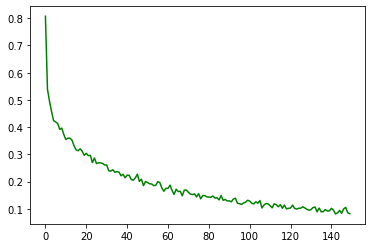

In [56]:
plt.plot(list(range(len(train_loss))),train_loss,'g',label='training loss')

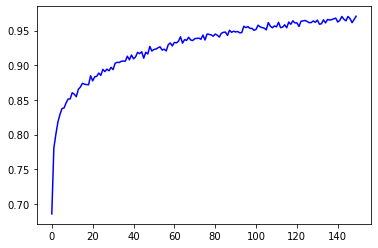

In [57]:
plt.plot(list(range(len(train_accuracy))),train_accuracy,'b',label='training accuracy')

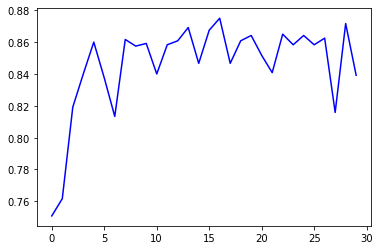

In [58]:
plt.plot(list(range(len(val_accuracy))),val_accuracy,'b',label='val accuracy')

In [59]:
model.load_weights(model_save+'17_secondary.h5')

In [60]:
history = model.evaluate(x=test_generator,
                             verbose=1,
                             return_dict = True)

38/38 [==============================] - 42s 1s/step - loss: 0.6554 - accuracy: 0.8492
